<a href="https://colab.research.google.com/github/sandeepaamcp/ECG_to_heart_rate_derivation/blob/dev/Heart_rate_predictions_from_ArXiv_1805_00794_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# THE MAIN SOURCE FOR THIS CODE IS https://www.kaggle.com/coni57/model-from-arxiv-1805-00794
# THE ASSOCIATED RESEARCH PAPER : https://arxiv.org/pdf/1805.00794
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from google.colab import drive
drive.mount('/content/drive')

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/datasets/test_results/csv/values.csv', header=None)
# df2 = pd.read_csv("../input/mitbih_test.csv", header=None)
# df = pd.concat([df, df2], axis=0)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
0,105.820,106.762,106.007,106.007,105.079,105.820,105.820,104.895,105.634,106.007,104.895,105.263,104.530,105.448,105.634,104.895,105.448,105.634,105.263,105.448,104.712,105.448,106.007,105.448,105.634,106.007,105.448,105.634,104.895,105.634,105.634,105.634,105.820,106.195,105.079,105.820,105.263,106.007,106.195,105.634,...,106.007,106.195,106.007,105.448,106.007,105.079,105.634,105.448,106.383,105.634,105.079,106.383,105.263,105.263,106.007,105.079,105.263,105.634,104.712,105.079,105.448,103.986,105.263,105.448,104.712,105.079,105.634,105.079,105.634,104.530,105.263,105.634,105.079,105.634,104.895,105.079,104.895,105.079,105.448,0
1,65.005,65.076,63.694,67.039,66.815,66.298,60.423,59.880,60.302,66.741,70.588,69.606,65.359,62.048,66.964,66.890,62.565,60.914,62.500,66.152,70.671,70.922,67.568,63.966,69.444,71.942,71.856,67.492,66.815,66.593,69.767,67.720,66.890,67.720,70.671,70.175,68.571,66.519,68.807,70.671,...,65.502,68.650,70.505,67.873,62.565,63.358,66.079,70.258,67.340,64.935,64.655,67.189,67.644,66.007,65.646,70.755,70.922,67.492,65.717,66.890,68.027,66.298,65.359,65.717,73.171,73.260,71.429,70.755,71.770,71.006,65.076,66.007,70.340,72.202,72.551,71.344,73.983,71.259,66.298,8
2,80.214,81.411,82.531,81.522,81.411,79.787,82.079,81.744,80.645,80.863,82.192,82.531,80.645,80.537,82.418,81.081,79.576,81.744,81.855,81.633,79.787,81.967,83.102,79.893,78.227,80.537,79.893,80.107,81.633,80.321,81.522,82.988,78.947,80.107,80.972,79.681,79.893,81.744,81.191,80.863,...,78.947,80.537,80.214,79.470,81.081,83.218,77.922,80.214,79.787,78.844,78.844,81.081,80.214,79.365,83.333,81.633,79.681,80.000,78.329,77.922,80.863,79.787,79.260,80.972,79.787,79.787,81.855,78.947,80.214,78.947,78.740,80.754,79.681,80.000,81.522,80.645,79.681,81.855,81.081,0
3,81.633,82.418,62.176,106.007,80.537,64.171,82.873,79.156,77.821,96.463,118.812,67.039,94.937,61.350,102.041,122.449,95.087,60.729,78.844,85.349,80.429,81.967,100.000,105.263,92.166,65.217,91.047,73.439,81.191,81.301,83.916,82.192,78.125,73.892,79.156,77.922,86.207,81.744,81.855,84.151,...,78.534,80.537,79.365,78.637,81.411,80.972,77.519,80.972,83.333,82.873,81.633,81.301,81.191,77.821,76.142,83.218,83.916,84.270,83.218,83.682,79.893,73.260,77.620,78.740,79.156,80.972,84.626,83.565,79.893,78.023,82.873,81.855,79.681,82.079,84.034,83.565,82.759,85.227,82.873,8
4,160.428,162.162,162.602,160.428,161.290,158.730,158.730,160.858,161.290,160.858,160.428,161.290,158.730,157.480,161.290,160.858,159.574,158.311,160.428,160.858,161.725,156.658,156.250,157.068,158.311,158.311,155.844,155.844,155.440,91.884,151.899,158.730,152.672,149.254,153.453,150.754,148.515,157.480,156.250,85.592,...,158.311,159.151,160.000,160.858,160.858,160.428,157.480,96.000,84.746,81.191,80.645,80.863,80.107,79.576,78.844,79.787,78.431,136.986,136.054,83.682,134.529,134.228,83.102,126.582,86.580,131.868,85.349,77.320,77.419,78.329,78.431,78.534,86.455,77.519,85.227,79.365,79.787,78.125,82.192,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Columns: 102 entries, 0 to 101
dtypes: float64(101), int64(1)
memory usage: 279.0 KB


In [5]:
df[101].value_counts()

0    230
8     83
2     15
1     14
6      4
3      3
5      1
Name: 101, dtype: int64

In [0]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [7]:
y

array([0, 8, 0, 8, 0, 8, 0, 8, 0, 1, 0, 0, 8, 0, 8, 2, 8, 8, 8, 8, 1, 8,
       8, 1, 8, 2, 8, 2, 2, 2, 0, 2, 0, 2, 0, 2, 5, 8, 2, 0, 0, 8, 8, 2,
       2, 8, 8, 1, 8, 8, 0, 2, 0, 3, 1, 2, 8, 2, 8, 8, 8, 1, 8, 0, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 8, 8, 8, 1, 8, 1, 8, 3,
       8, 0, 8, 8, 8, 0, 8, 1, 6, 8, 8, 8, 8, 0, 6, 8, 0, 8, 6, 0, 6, 0,
       0, 8, 0, 8, 8, 8, 8, 3, 8, 0, 8, 0, 8, 1, 8, 1, 8, 0, 8, 8, 0, 8,
       0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# del df
# del df2
# del M

# Visual Input

In [9]:
C0 = np.argwhere(y == 0).flatten()
C8 = np.argwhere(y == 8).flatten()

print(C8)

[  1   3   5   7  12  14  16  17  18  19  21  22  24  26  37  41  42  45
  46  48  49  56  58  59  60  62  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  80  81  82  84  86  88  90  91  92  94  97  98  99 100
 103 105 111 113 114 115 116 118 120 122 124 126 128 129 131 135 328 335
 336 337 338 339 340 341 342 343 344 346 349]


In [10]:
print(X[C0,:])

[[105.82  106.762 106.007 ... 104.895 105.079 105.448]
 [ 80.214  81.411  82.531 ...  79.681  81.855  81.081]
 [160.428 162.162 162.602 ...  79.787  78.125  82.192]
 ...
 [ 70.588  71.344  71.006 ...  71.77   70.838  70.838]
 [ 70.093  69.606  69.045 ...  65.862  63.694  62.959]
 [ 60.241  60.241  59.88  ...  63.559  63.694  61.1  ]]


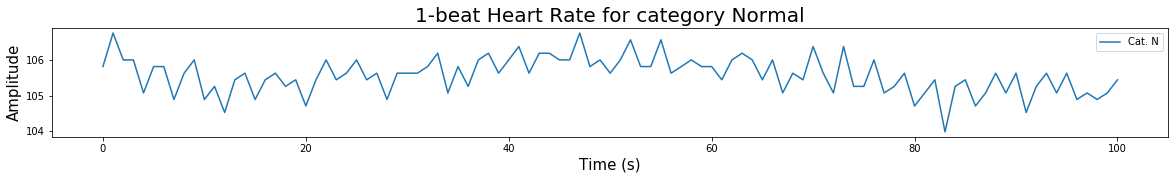

In [11]:
x = np.arange(0, 101)
X[C8, :][0].shape
plt.figure(figsize=(20,2))
plt.plot(x, X[C0, :][0], label="Cat. N")
# plt.plot(x, X[C1, :][0], label="Cat. S")
# plt.plot(x, X[C2, :][0], label="Cat. V")
# plt.plot(x, X[C3, :][0], label="Cat. F")
# plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat Heart Rate for category Normal", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.show()

In [12]:
print(X)

[[105.82  106.762 106.007 ... 104.895 105.079 105.448]
 [ 65.005  65.076  63.694 ...  73.983  71.259  66.298]
 [ 80.214  81.411  82.531 ...  79.681  81.855  81.081]
 ...
 [ 60.241  60.241  59.88  ...  63.559  63.694  61.1  ]
 [ 70.505  70.838  69.686 ...  68.182  66.593  65.717]
 [ 66.372  72.816  77.32  ...  61.538  62.762  70.755]]


# Split

In [0]:
trainMCI = np.random.choice(C0, 80)
trainNorm = np.random.choice(C8, 80)

In [14]:
trainNorm

array([  7,   3,  14, 100,   7, 100, 120,  45,  84,  71, 337, 118,  26,
        91,  37, 335, 341, 118,  77, 343, 346,  99,  59,  62, 115,  80,
        66,  37,  86, 124, 328,  18,   1,  17, 120,  21, 344,  17,  72,
        72,  70,  12,  80,  65,  16, 336, 335,  22,  71,  70,  91,  58,
       118,  74,  84,  72, 124,  90, 341,   5,   1,  12,  26,  64,  18,
       342,  37,  81, 340,  97, 120,  98,   7,  58,  37,  82,  66,  73,
        24,  69])

In [15]:
testMCI = np.random.choice(C0, 20)
testNorm = np.random.choice(C8, 20)
testNorm

array([118,   1,  64, 118, 340,   5, 135, 335,  64,  18, 118,  74,  97,
        84,  59, 342, 114,  69,  98, 118])

In [16]:
np.vstack([X[trainMCI], X[trainNorm]]).shape

(160, 101)

In [17]:
np.hstack([y[trainMCI], y[trainNorm]]).shape

(160,)

In [0]:
# np.hstack([y[subC0], y[subC1]])

In [19]:
X_test = np.vstack([X[testMCI], X[testNorm]])
y_test = np.hstack([y[testMCI], y[testNorm]])

X_train = np.vstack([X[trainMCI], X[trainNorm]])
y_train = np.hstack([y[trainMCI], y[trainNorm]])

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# del X
# del y

print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
# print(X.shape)

(40, 101)
(160, 101)
(40,)
(160,)


In [20]:
y_test

array([8, 8, 8, 0, 0, 0, 8, 0, 0, 8, 8, 8, 8, 0, 8, 8, 8, 0, 8, 0, 0, 0,
       0, 0, 8, 0, 8, 0, 8, 0, 8, 8, 0, 8, 8, 0, 0, 8, 0, 0])

In [0]:
y_test = np.where(y_test > 1, 1, 0)
y_train = np.where(y_train > 1, 1, 0)

In [0]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [23]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160, 101, 1)
y_train (160,)
X_test (40, 101, 1)
y_test (40,)


In [0]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [25]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160, 101, 1)
y_train (160, 2)
X_test (40, 101, 1)
y_test (40, 2)


# Model

Now let's re-create the model from the ArXiv Document

In [0]:
n_obs, feature, depth = X_train.shape
batch_size = 80

In [27]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(2)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 97, 32)       192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 97, 32)       5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 97, 32)       0           conv1d_2[0][0]                   
__________

In [0]:
def exp_decay(epoch):
    initial_lrate = 0.002
    k = 0.75
    t = n_obs//(batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [0]:
adam = Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])

In [31]:
# It is observed that sometimes the accuracy won't change for epochs. 
# This is likely to happen due to Adam optimizer found a local minima
# Source : https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change/53397560#53397560
history = model.fit(X_train, y_train, 
                    epochs=300, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])


Train on 160 samples, validate on 40 samples
Epoch 1/300
160/160 [==============================] - 1s 4ms/step - loss: 16.3956 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5250
Epoch 2/300
160/160 [==============================] - 0s 745us/step - loss: 8.0236 - accuracy: 0.5063 - val_loss: nan - val_accuracy: 0.5250
Epoch 3/300
160/160 [==============================] - 0s 661us/step - loss: 3.2250 - accuracy: 0.5688 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/300
160/160 [==============================] - 0s 661us/step - loss: 3.6954 - accuracy: 0.4875 - val_loss: nan - val_accuracy: 0.6000
Epoch 5/300
160/160 [==============================] - 0s 685us/step - loss: 1.8845 - accuracy: 0.5875 - val_loss: nan - val_accuracy: 0.5250
Epoch 6/300
160/160 [==============================] - 0s 695us/step - loss: 2.6400 - accuracy: 0.5125 - val_loss: nan - val_accuracy: 0.5750
Epoch 7/300
160/160 [==============================] - 0s 686us/step - loss: 1.6574 - accuracy: 0.5437 

In [0]:
y_pred = model.predict(X_test, batch_size=80)

In [37]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.85      0.76        20
           1       0.80      0.60      0.69        20

    accuracy                           0.73        40
   macro avg       0.74      0.72      0.72        40
weighted avg       0.74      0.72      0.72        40



In [0]:
# print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
# print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
# print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

Confusion matrix, without normalization


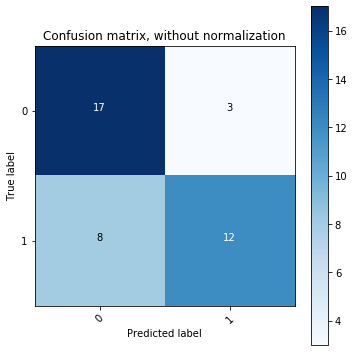

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')
plt.show()